<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex02/Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Marcus Vinicius Borela de Castro

# Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

# Fixando a seed

In [ ]:
import random
import torch
import numpy as np

In [ ]:
def inicializa_seed():
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  #torch.cuda.manual_seed(123)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [ ]:
inicializa_seed()

# Configuração para rastro (neptune.ai)



### Importação de libraries para Rastro

In [ ]:
pip install neptune-client

     |████████████████████████████████| 315 kB 10.1 MB/s 
     |████████████████████████████████| 829 kB 41.2 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 181 kB 42.7 MB/s 
     |████████████████████████████████| 132 kB 42.4 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 8.6 MB 32.2 MB/s 
     |████████████████████████████████| 138 kB 18.3 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 127 kB 44.2 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 130 kB 44.5 MB/s 
     |████████████████████████████████| 64 kB 1.3 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565173 sha256=a63e9d60177c97bf041a80a9bf696525dc6c13ca56804a6f5930faf45b4d8cb8
  Stored in directory: /root/.cache/pip/wheels/4f/ff/e6/2128c7fd2e85bd327f524d44b079

In [ ]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=2dab7b41ce6a6ad256c854f98b940c1c49bf850fd69f9c4824401407c2afc63d
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
import getpass
import copy
from torchviz import make_dot
import neptune.new as neptune
import time
import re
import tempfile
import os

### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [ ]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [ ]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))

        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [ ]:
# NEPTUNE_API_TOKEN = getpass.getpass('Informe NEPTUNE_API_TOKEN')

In [ ]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 2 - regressão liner e gráfico do custo com mínimo encontrado',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Detalhamento dos dados


## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Carga dos Dados: leitura e visualização


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


### Visualização dos dados `x_in` e `y_in` e normalizados

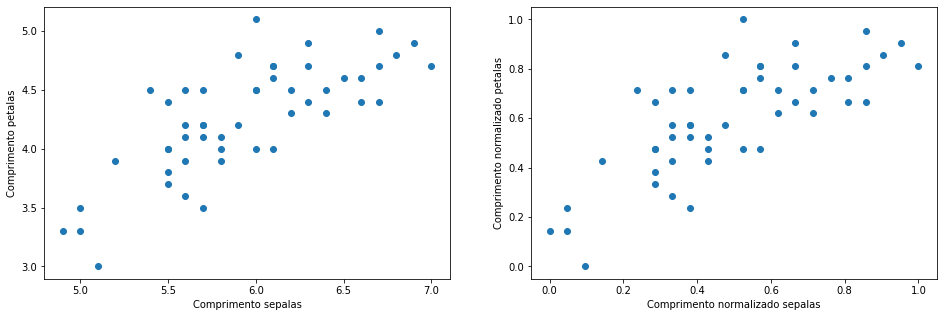

In [ ]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Transformando dados em dataset/dataloader


In [ ]:
from torch.utils.data import DataLoader, Dataset

### Dataset

In [ ]:

class Dados(Dataset):
  def __init__(self, x, y):
    print(f"Dados: len(x) {len(x)} len(y) {len(y)}")
    self.x = torch.from_numpy(np.float32(x))
    self.y = torch.from_numpy(np.float32(y))


  def __len__(self):
    return len(self.x)

  def __getitem__(self, item):
    """
    target = self.targets[item]
    encoding = tokenizer(
      x[0],
      padding=True,
      add_special_tokens=True,
      max_length=250,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
    """
    return {
     # 'review_text': review,
      'x': self.x[item] ,
      'y': self.y[item]
    }

#### Testes do dataset

In [ ]:
type(y)


numpy.ndarray

In [ ]:
x[0:5], y[0:5]

(array([[1.        ],
        [0.71428571],
        [0.95238095],
        [0.28571429],
        [0.76190476]]), array([[0.80952381],
        [0.71428571],
        [0.9047619 ],
        [0.47619048],
        [0.76190476]]))

In [ ]:
ds = Dados(x,y)

Dados: len(x) 50 len(y) 50


In [ ]:
print(len(ds))

50


In [ ]:
ds[0], ds[3]

({'x': tensor([1.]), 'y': tensor([0.8095])},
 {'x': tensor([0.2857]), 'y': tensor([0.4762])})

### Dataloader

In [ ]:
dados_loader = DataLoader(ds, batch_size=len(ds), shuffle=True)

#### Testes do dataloader

In [ ]:
x_ = next(iter(dados_loader))

print("\nDimensões dos dados de um minibatch X:", x_['x'].size())
print("\nDimensões dos dados de um minibatch Y:", x_['y'].size())


Dimensões dos dados de um minibatch X: torch.Size([50, 1])

Dimensões dos dados de um minibatch Y: torch.Size([50, 1])


# Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

# Implementação

## Funções: Custo, Gradiente Descendente

## Definição do Modelo


In [ ]:
class Model(torch.nn.Module): 
  """
  Implements a LinearRegressionModel with torch.nn
  """
  def __init__(self, n_in: int, n_out: int):
    super().__init__()  
    self.linear = torch.nn.Linear(n_in, n_out, bias=True)  # One in and one out
    self.linear.weight
    torch.nn.init.zeros_(self.linear.weight)
    torch.nn.init.zeros_(self.linear.bias)
    print(f"Pesos shape: {self.linear.weight.shape} ")
    print(f"Pesos: {self.linear.weight} ")
    print(f"Bias shape: {self.linear.bias.shape} ")
    print(f"Bias: {self.linear.bias} ")

  def forward(self, x):
    y_pred = self.linear(x)
    return y_pred

### Teste do modelo

In [ ]:
xtemp = torch.arange(0,4).float(); x

tensor([0., 1., 2., 3.])

In [ ]:
xtemp = xtemp.reshape(-1,1)

In [ ]:
xtemp.shape

torch.Size([4, 1])

In [ ]:
model_test=Model(1,1)

Pesos shape: torch.Size([1, 1]) 
Pesos: Parameter containing:
tensor([[0.]], requires_grad=True) 
Bias shape: torch.Size([1]) 
Bias: Parameter containing:
tensor([0.], requires_grad=True) 


In [ ]:
model_test(x)

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddmmBackward0>)

In [ ]:
model_test.linear.weight.reshape(1,)

tensor([0.], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
model_test.linear.bias

Parameter containing:
tensor([0.], requires_grad=True)

### Experimentações de cat e stack

In [ ]:
x = torch.cat((model_test.linear.bias, model_test.linear.weight.reshape(1,)))

In [ ]:
c = 1
c = torch.tensor(c, dtype=torch.int8);c

tensor(1, dtype=torch.int8)

In [ ]:
torch.reshape(c, (1,))

tensor([1], dtype=torch.int8)

In [ ]:
bbias = model_test.linear.bias; bbias

Parameter containing:
tensor([0.], requires_grad=True)

In [ ]:
torch.stack((bbias, torch.reshape(c, (1,))))

tensor([[0.],
        [1.]], grad_fn=<StackBackward0>)

In [ ]:
pesos = torch.cat((model_test.linear.bias, model_test.linear.weight.reshape(1,))); pesos

tensor([0., 0.], grad_fn=<CatBackward0>)

In [ ]:
pesos.shape

torch.Size([2])

In [ ]:
pesos_0 = pesos.reshape(1,2); pesos_0

tensor([[0., 0.]], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
pesos_1 = torch.cat((pesos_0, pesos.reshape(1,2))); pesos_1

tensor([[0., 0.],
        [0., 0.]], grad_fn=<CatBackward0>)

In [ ]:
pesos_2 = torch.cat((pesos_1, pesos.reshape(1,2))); pesos_2

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<CatBackward0>)

## Métricas

In [ ]:
def calcula_loss_tensor(outputs, target, parm_criterion):
  #print(f'entrei calcula_loss outputs type: {type(outputs)} shape: {outputs.shape} target type: {type(target)} shape: {target.shape}')
  if isinstance(parm_criterion, torch.nn.MSELoss):
    #print('é instancia de torch.nn.CrossEntropyLoss')
    return parm_criterion(outputs, target)


## Definição do treinamento

### hparam: HiperParametros

In [ ]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam['max_epochs'] = 21
  hparam["learning_rate"] = 0.5  
  #criterion = torch.nn.CrossEntropyLoss(weight=pesos_classes)
  hparam['criterion'] = torch.nn.MSELoss(reduction = 'mean') # torch.nn.CrossEntropyLoss()  
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(dev))    
  return hparam

In [ ]:
def validar_hparam(parm_hparam:dict, parm_lista_chaves_esperadas=['max_epochs', 'criterion', 'optimizer', 'device'] ):
  """
  Valida se hparam tem as chaves esperadas em parm_lista_chaves_esperadas
  """
  if sum([key in hparam for key in parm_lista_chaves_esperadas]) != len(parm_lista_chaves_esperadas):
              raise Exception(f'Está faltando parâmetro esperado para treinamento em hparam \
                  {[key for key in parm_lista_chaves_esperadas if key not in hparam]}')

In [ ]:
hparam=inicia_hparam()


### Funções

In [ ]:
def treina_modelo_com_rastro (parm_model, parm_loader_train, hparam:dict, rastro_neptune, intervalo_print:int = 10):
  """Train a model following hparam directives

  Returns:
      loss_history: a torch.tensor of shape (n_epochs,)
      w_history: a torch.tensor of shape (n_epochs, 2)
      rastro_history (rastro with metrics)
  """
  rastro_history = []
  print(f'Iniciado treinamento em {time.strftime("%Y-%b-%d %H:%M:%S")}')
  for cnt_epoca in range(1, hparam['max_epochs']+1):
    accumulated_loss = 0
    accumulated_accuracy = 0
    parm_model.train()
    cnt_step = 0
    for idx, batch in enumerate(parm_loader_train):
      # print(f"cnt_epoca {cnt_epoca} idx {idx} len(batch['x']): {len(batch['x'])} ")
      cnt_step += 1
      x = batch["x"].to(hparam['device'])
      y = batch["y"].to(hparam['device'])
      outputs = parm_model(x)

      # calcula a perda
      batch_loss = calcula_loss_tensor(outputs, y, hparam['criterion'])

      # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
      batch_loss.backward()
      
      # salva no rastro
      metrica_rastro = {"train/loss": batch_loss.item()}  
      rastro_neptune.salva_metrica(metrica_rastro)
      rastro_history.append(metrica_rastro)

      # outros dados a retornar
      pesos = torch.cat((parm_model.linear.bias, parm_model.linear.weight.reshape(1,)))
      if cnt_epoca == 1:
        # print(f"type(batch_loss) {type(batch_loss)}")
        loss_history = torch.reshape(batch_loss, (1,)) 
        w_history = pesos.reshape(1,2)
        # print(f"cnt_epoca {cnt_epoca} loss_history:{loss_history} w_history: {w_history} ")
      else:
        loss_history = torch.cat((loss_history, torch.reshape(batch_loss, (1,)) ))
        w_history = torch.cat((w_history, pesos.reshape(1,2)))

      #print(f'Efetuando cálculo gradiente')
      hparam['optimizer'].step()
      # Reset gradients, for the next accumulated batches
      hparam['optimizer'].zero_grad()

      loss_treino = batch_loss
      if intervalo_print > 0:
        if (cnt_epoca)%intervalo_print == 0: 
          print(f'cnt_epoca {(cnt_epoca):d}/{hparam["max_epochs"]:d} em {time.strftime("%Y-%b-%d %H:%M:%S")} Train Loss: {loss_treino:.6f} ')
          print(f"           loss_history:{loss_history} w_history: {w_history} ")
         
  return loss_history, w_history, rastro_history

### Testando as funções

In [ ]:
model = Model(1, 1) # duas entradas (1 + x0) e uma saída y_pred

Pesos shape: torch.Size([1, 1]) 
Pesos: Parameter containing:
tensor([[0.]], requires_grad=True) 
Bias shape: torch.Size([1]) 
Bias: Parameter containing:
tensor([0.], requires_grad=True) 


In [ ]:
model.to(hparam['device'])
hparam['optimizer'] = torch.optim.SGD(model.parameters(), lr=hparam['learning_rate']) #torch.optim.Adam(model.parameters(), lr=hparam["learning_rate"])
print(f"hparam: {hparam}")
validar_hparam(hparam, ['max_epochs', 'criterion', 'optimizer', 'device'])


hparam: {'max_epochs': 21, 'learning_rate': 0.5, 'criterion': MSELoss(), 'device': device(type='cpu'), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)}


In [ ]:
rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=["execução final"])   

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-6
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
loss_history, w_history, rastro_history = treina_modelo_com_rastro(model, dados_loader, hparam, rastro_neptune, intervalo_print=100)

Iniciado treinamento em 2022-Mar-27 22:57:24


In [ ]:
loss_history = loss_history.detach().numpy()
w_history = w_history.detach().numpy()

In [ ]:
loss_history, w_history, rastro_history

(array([0.40907028, 0.05599688, 0.03208511, 0.02972903, 0.02885258,
        0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
        0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
        0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
        0.02280539], dtype=float32), array([[0.        , 0.        ],
        [0.59999996, 0.33664396],
        [0.43392235, 0.27542454],
        [0.4641239 , 0.31466082],
        [0.44476733, 0.32712537],
        [0.43861815, 0.34536758],
        [0.4296187 , 0.36112356],
        [0.4218457 , 0.37655175],
        [0.4142345 , 0.39114627],
        [0.40703452, 0.40507957],
        [0.40016076, 0.41834885],
        [0.39361456, 0.4309941 ],
        [0.38737625, 0.44304255],
        [0.38143235, 0.45452288],
        [0.37576872, 0.46546176],
        [0.3703722 , 0.47588477],
        [0.3652302 , 0.4858162 ],
        [0.36033067, 0.49527925],
        [0.35566226, 0.504296  ],
        [0.351214  , 0.51288754],
        [0.3

In [ ]:
rastro_neptune.gera_grafico_modelo(dados_loader, model)   

In [ ]:
rastro_neptune.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!


In [ ]:
# Assert do histórico de losses
target_loss_history = np.array(
    [0.40907029, 0.0559969 , 0.03208511, 0.02972902, 0.02885257,
     0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
     0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
     0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
     0.0228054])


In [ ]:
assert np.allclose(loss_history, target_loss_history, atol=1e-6)

In [ ]:
# Assert de histórico de pesos da rede
target_w_history = np.array(
    [[0.,         0.        ],
    [0.6,        0.336644  ],
    [0.4339223,  0.27542454],
    [0.4641239,  0.31466085],
    [0.44476733, 0.3271254 ],
    [0.43861815, 0.3453676 ],
    [0.42961866, 0.3611236 ],
    [0.4218457,  0.37655178],
    [0.41423446, 0.3911463 ],
    [0.40703452, 0.4050796 ],
    [0.40016073, 0.41834888],
    [0.39361456, 0.43099412],
    [0.38737625, 0.44304258],
    [0.38143232, 0.4545229 ],
    [0.3757687,  0.4654618 ],
    [0.37037218, 0.4758848 ],
    [0.36523017, 0.48581624],
    [0.36033067, 0.49527928],
    [0.35566223, 0.50429606],
    [0.35121396, 0.5128876 ],
    [0.34697545, 0.52107394]])


In [ ]:
assert np.allclose(w_history, target_w_history, atol=1e-6)

# Função de cálculo do grid de custos

### Montando os valores dos eixos com sobra da diferença nos eixos do gráfico

In [ ]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
wmin, wmax

(array([0., 0.], dtype=float32),
 array([0.59999996, 0.5210739 ], dtype=float32))

In [ ]:
D =  wmax - wmin; D

array([0.59999996, 0.5210739 ], dtype=float32)

In [ ]:
wmin -= D
wmax += D
wmin, wmax

(array([-0.59999996, -0.5210739 ], dtype=float32),
 array([1.1999999, 1.0421478], dtype=float32))

In [ ]:
w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

### Calculando a loss no grid de valores dos pesos

In [ ]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """
      Objetivo: retornar o valor da função de custo considerando os valores
        passados dos pesos nos eixos do gráfico: horizontal (w_0_grid) e
        vertical (w_1_grid).

      Para fins ilustrativos, consideremos:
        len(w_0_grid)=len(w_0_grid)=100 (não precisariam ser iguais)
        len(x)=len(y)=50 (precisam ter tamanhos iguais)

      Returns:
        loss_grid: an array with the same shape of w_0_grid x w_1_grid. 
        No caso, de 100 números para cada eixo, será retornado array com 2 dimensões
        com 100 em cada: (100, 100) referentes aos valores da função de custo 
        em cada par, para montar o gráfico.  

      Obs.: antes de implementar, tomei por base solução do colega Edmar Rodrigues
    """
    # gera as combinações possíveis
    #   duplica os valores dos vetores: [[a, b,...], [a,b,...]]
    #   cada um em uma dimensão, para permitir passos seguintes
    #  :: tamanho ww0 no exemplo: 100 x 100
    ww0, ww1 = np.meshgrid(w_0_grid, w_1_grid)
    #   ravel: concatena os vetores em uma única dimensão:[a,b,...a,b,...]
    #   concatena os arrays ao longo do último eixo
    #  :: tamanho w_grid 10mil pares (100 x 100)
    w_grid = np.stack((ww0.ravel(), ww1.ravel()), axis=1)
    # Calculo da função de custo para todos os pares de pesos considerados
    #   Para cada par, multiplicar w0 por todos valores em X e subtrair
    #   de y. E calcular seu quadrado, para todos os valores de x,y
    #  :: tamanho loss_grid 50 (pares x, y) x 10000 (w_grid)
    loss_grid = (((w_grid[:,0] + w_grid[:,1]*x) - y)**2)
    # Pegar a média da quadrados das diferenças no eixo do número de amostras (50)
    #  :: tamanho 10mil
    loss_grid = loss_grid.mean(axis=0)
    # Reorganizar o array para voltar aos valores da função para os 
    #   O -1 indica que a última dimensão (1) terá seu tamanho ajustado automaticamente
    #  :: tamanho (100 x 100)
    loss_grid = loss_grid.reshape((w_0_grid.shape[0],-1))    
    return loss_grid

In [ ]:
loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

### Testando a função

In [ ]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [ ]:
target_loss_grid.shape, type(target_loss_grid)

((100, 100), numpy.ndarray)

In [ ]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6) 

## Funcão de Plot

In [ ]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

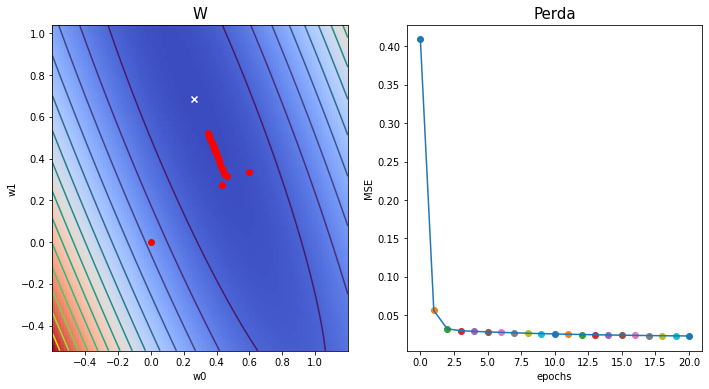

In [ ]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass

# Outras experimentações

### Testando comandos para compreensão da função de grid para construção do gráfico

In [ ]:
w_0_grid.shape, w_0_grid[:10],w_0_grid[-10:],

((100,),
 array([-0.59999996, -0.58181815, -0.56363633, -0.54545451, -0.5272727 ,
        -0.50909088, -0.49090906, -0.47272724, -0.45454543, -0.43636361]),
 array([1.03636357, 1.05454539, 1.07272721, 1.09090903, 1.10909084,
        1.12727266, 1.14545448, 1.16363629, 1.18181811, 1.19999993]))

In [ ]:
w_1_grid.shape, w_1_grid[:10],w_1_grid[-10:],

((100,),
 array([-0.52107388, -0.50528376, -0.48949364, -0.47370353, -0.45791341,
        -0.44212329, -0.42633317, -0.41054306, -0.39475294, -0.37896282]),
 array([0.9000367 , 0.91582682, 0.93161693, 0.94740705, 0.96319717,
        0.97898729, 0.9947774 , 1.01056752, 1.02635764, 1.04214776]))

In [ ]:
 ww0, ww1 = np.meshgrid(w_0_grid, w_1_grid)

In [ ]:
ww0.shape, ww0[:2,:10]

((100, 100),
 array([[-0.59999996, -0.58181815, -0.56363633, -0.54545451, -0.5272727 ,
         -0.50909088, -0.49090906, -0.47272724, -0.45454543, -0.43636361],
        [-0.59999996, -0.58181815, -0.56363633, -0.54545451, -0.5272727 ,
         -0.50909088, -0.49090906, -0.47272724, -0.45454543, -0.43636361]]))

In [ ]:
ww1.shape, ww1[:2,:10]

((100, 100),
 array([[-0.52107388, -0.52107388, -0.52107388, -0.52107388, -0.52107388,
         -0.52107388, -0.52107388, -0.52107388, -0.52107388, -0.52107388],
        [-0.50528376, -0.50528376, -0.50528376, -0.50528376, -0.50528376,
         -0.50528376, -0.50528376, -0.50528376, -0.50528376, -0.50528376]]))

In [ ]:
w_grid = np.c_[ww0.ravel(), ww1.ravel()]

In [ ]:
w_grid2 = np.stack((ww0.ravel(), ww1.ravel()), axis=1)

In [ ]:
w_grid2.shape

(10000, 2)

In [ ]:
w_grid2[0:10],w_grid2[-10:]

(array([[-0.59999996, -0.52107388],
        [-0.58181815, -0.52107388],
        [-0.56363633, -0.52107388],
        [-0.54545451, -0.52107388],
        [-0.5272727 , -0.52107388],
        [-0.50909088, -0.52107388],
        [-0.49090906, -0.52107388],
        [-0.47272724, -0.52107388],
        [-0.45454543, -0.52107388],
        [-0.43636361, -0.52107388]]), array([[1.03636357, 1.04214776],
        [1.05454539, 1.04214776],
        [1.07272721, 1.04214776],
        [1.09090903, 1.04214776],
        [1.10909084, 1.04214776],
        [1.12727266, 1.04214776],
        [1.14545448, 1.04214776],
        [1.16363629, 1.04214776],
        [1.18181811, 1.04214776],
        [1.19999993, 1.04214776]]))

In [ ]:
w_grid.shape

(10000, 2)

In [ ]:
w_grid[0:10],w_grid[-10:]

(array([[-0.59999996, -0.52107388],
        [-0.58181815, -0.52107388],
        [-0.56363633, -0.52107388],
        [-0.54545451, -0.52107388],
        [-0.5272727 , -0.52107388],
        [-0.50909088, -0.52107388],
        [-0.49090906, -0.52107388],
        [-0.47272724, -0.52107388],
        [-0.45454543, -0.52107388],
        [-0.43636361, -0.52107388]]), array([[1.03636357, 1.04214776],
        [1.05454539, 1.04214776],
        [1.07272721, 1.04214776],
        [1.09090903, 1.04214776],
        [1.10909084, 1.04214776],
        [1.12727266, 1.04214776],
        [1.14545448, 1.04214776],
        [1.16363629, 1.04214776],
        [1.18181811, 1.04214776],
        [1.19999993, 1.04214776]]))

In [ ]:
loss_grid = (((w_grid[:,0] + w_grid[:,1]*x) - y)**2)

In [ ]:
loss_grid.shape, loss_grid[0:3],loss_grid[-3:]

((50, 10000),
 array([[3.72720729, 3.65733432, 3.58812251, ..., 1.94954266, 2.00064633,
         2.05241117],
        [2.84421919, 2.78322318, 2.72288833, ..., 1.42501957, 1.46875894,
         1.51315946],
        [4.00409187, 3.93165799, 3.85988526, ..., 1.5659921 , 1.61182799,
         1.65832503]]),
 array([[2.37658337, 2.32085514, 2.26578808, ..., 1.41545215, 1.45904555,
         1.50330011],
        [0.422014  , 0.39872182, 0.37609079, ..., 1.59488727, 1.64114106,
         1.68805601],
        [1.74851385, 1.70076029, 1.65366789, ..., 1.07502773, 1.11306141,
         1.15175625]]))

In [ ]:
loss_grid = loss_grid.mean(axis=0)

In [ ]:
loss_grid.shape, loss_grid[0:3],loss_grid[-3:]

((10000,),
 array([2.23053598, 2.17788245, 2.12589008]),
 array([1.1902316 , 1.22975354, 1.26993664]))